# Fine tuning a classifier in scikit-learn
https://www.kaggle.com/kevinarvai/fine-tuning-a-classifier-in-scikit-learn

Importamos las librerias a utilizar y cargamos los datos pre-procesados

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [2]:
df = pd.read_csv('../data/prueba.csv')

df.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,m_jj,deltaR_j12,label,n_hadrones
0,1286.727685,106.912129,0.185508,-2.763676,1313.290435,0.624659,1283.220733,63.164215,0.064989,0.393688,1287.481934,0.713248,170.076344,3.159663,0.0,109.000000
1,1354.394070,614.269108,0.826505,1.365524,1943.559886,0.311688,1325.613761,439.064150,-0.874319,-1.786248,1916.370744,0.276881,1053.333258,3.581406,0.0,208.000000
2,1214.955723,645.865619,-0.196786,2.040545,1396.840654,0.238205,1072.462085,113.768840,0.143831,-1.090330,1089.530630,0.726963,759.634459,3.149348,0.0,196.000000
3,1285.227873,516.835248,0.328693,2.975321,1450.485926,0.013429,1220.251279,174.796077,0.294854,-0.322661,1285.618789,0.706361,691.631325,3.298155,0.0,183.000000
4,1210.415787,129.499352,-0.744836,-2.883347,1567.345300,0.423550,1091.785816,155.362262,1.060534,0.264977,1772.340209,0.787662,284.861613,3.629229,1.0,169.333333


In [3]:
# Hacemos un sample random de estos eventos
df = df.sample(n=1000)
df.shape

(1000, 16)

Vemos cuanta señal y fondo hay en la muestra

In [4]:
# class distribution
# label: Fondo = 0, Señal = 1
df['label'].value_counts()

0.0    922
1.0     78
Name: label, dtype: int64

Separamos la muestra para entrenamiento y prueba:

In [5]:
# Definimos una función para separar un dataframe en caracteristicas y label

def data_ready(df, label='label'):
    
    # Creamos una lista con las características a considerar en el modelo
    carac_cols = df.columns.values.tolist()
    
    # Eliminamos 'label' porque no es una característica
    carac_cols.remove(label)

    # Hacemos un dataframe solo con las características
    X = df[carac_cols]

    # Obtenemos la serie con la información sobre señal o fondo
    y = df[label]
    
    return X, y

In [6]:
# by default majority class (benign) will be negative
lb = LabelBinarizer()
df['label'] = lb.fit_transform(df['label'].values)
df, targets = data_ready(df)

X_train, X_test, y_train, y_test = train_test_split(df, targets, stratify=targets)

Vemos que la distribución de clases coincida en ambos datos

In [7]:
print('y_train class distribution')
print(y_train.value_counts(normalize=True))

print('y_test class distribution')
print(y_test.value_counts(normalize=True))

y_train class distribution
0    0.922667
1    0.077333
Name: label, dtype: float64
y_test class distribution
0    0.92
1    0.08
Name: label, dtype: float64


## First strategy: Optimize for sensitivity using GridSearchCV with the scoring argument.

Primero se construye un clasificador genérico y se configura una cuadrícula de parámetros; Los Random Forest tienen muchos parámetros ajustables, lo que los hace adecuados para GridSearchCV

In [8]:
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [9]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search, y_pred

In [10]:
grid_search_clf , y_pred = grid_search_wrapper(refit_score='precision_score')

C:\Users\maria\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.9        0.9        0.8        0.9        0.85       0.8
 0.91       0.91       0.90166667 0.91       0.91       0.825
 0.9        0.9        0.89809524 0.91       0.725      0.92666667
        nan        nan        nan        nan        nan        nan
 0.95       0.94333333 0.96       0.975      0.94       0.96
 0.95714286 0.95714286 0.96666667 0.96       0.96666667 0.96666667
 0.9        0.88333333 0.90047619 0.9        0.90833333 0.90833333
        nan        nan        nan        nan        nan        nan
 0.95714286 0.96666667 0.86666667 0.96666667 0.95       0.96666667
 0.93214286 0.95714286 0.93       0.95714286 0.95714286 0.96666667
 0.91547619 0.91547619 0.8875     0.90047619 0.87547619 0.94047619
        nan        nan        nan        nan        nan        nan
 0.96       0.96666667 0.95714286 0.96666667 0.96333333 0.98
 0.9428571

Best params for precision_score
{'max_depth': 25, 'max_features': 3, 'min_samples_split': 10, 'n_estimators': 300}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg       230         0
pos        11         9


In [11]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score',
         'param_max_depth', 'param_max_features', 'param_min_samples_split',
         'param_n_estimators']].head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
77,0.980000,0.486667,0.958667,25,3,10,300
27,0.975000,0.450000,0.956000,5,3,5,300
80,0.966667,0.523333,0.960000,25,5,5,100
59,0.966667,0.523333,0.960000,15,5,10,300
32,0.966667,0.503333,0.958667,5,5,5,100


In [12]:
X_test['pred'] = y_pred
X_test.head()

<ipython-input-12-f01c86021f89>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['pred'] = y_pred


,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,m_jj,deltaR_j12,n_hadrones,pred
44180,1537.309450,303.448549,-0.225731,2.493708,1605.578676,0.564193,1260.457095,36.597861,1.082809,-0.573339,2074.786197,0.787685,340.046410,3.334524,146.0,0
10157,1507.522044,651.143290,0.238898,1.695591,1681.903831,0.203073,1491.614789,322.676061,0.265708,-1.460641,1577.924840,0.053450,973.819351,3.156346,174.0,0
24142,1496.671457,66.161674,-0.799884,1.159423,2002.640124,0.790490,1418.273727,160.100536,-0.242038,-1.873290,1468.771578,0.625889,226.262210,3.083592,213.0,0
2074,1435.214715,188.020006,0.463876,-0.982730,1603.480499,0.913578,1414.295610,34.655229,-0.954789,2.125690,2109.716899,0.725047,222.675235,3.416853,156.0,0
39942,1575.642223,75.189229,-0.056134,-1.739455,1579.915509,0.695679,1500.286497,47.564472,0.340090,1.383718,1588.600771,0.850589,122.753701,3.148206,93.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27187,1371.519557,58.888494,1.103841,-1.864608,2296.213728,0.707037,1354.400160,279.292141,-0.877957,1.275016,1931.098428,0.219238,338.180636,3.712784,104.0,0
42963,1300.474831,536.704233,-0.442375,-1.149363,1527.224392,0.243567,1160.480798,204.745873,-0.363688,1.965001,1254.893914,0.330511,741.450106,3.115358,160.0,0
13312,1843.044971,113.309947,0.180697,0.158994,1876.639684,0.935872,1634.077131,213.557547,0.695235,-2.976449,2056.279471,0.768617,326.867494,3.177382,179.0,0
38587,1353.746256,274.160215,0.126326,0.747291,1391.831202,0.286977,1308.123755,55.172268,0.206759,-2.420551,1337.322827,0.299698,329.332483,3.168863,131.0,0


array([[<AxesSubplot:title={'center':'pT_j1'}>]], dtype=object)

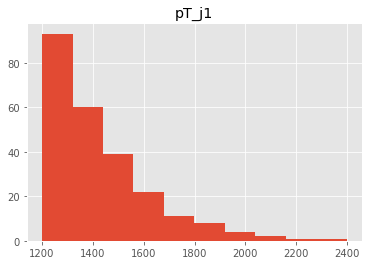

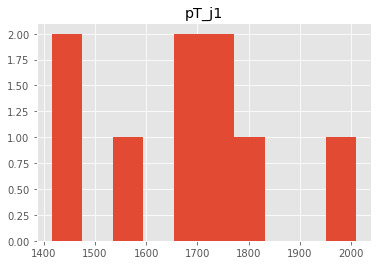

In [16]:
X_test.loc[X_test['pred']==0].hist('pT_j1', color='blue')
X_test.loc[X_test['pred']==1].hist('pT_j1')

array([[<AxesSubplot:title={'center':'m_jj'}>]], dtype=object)

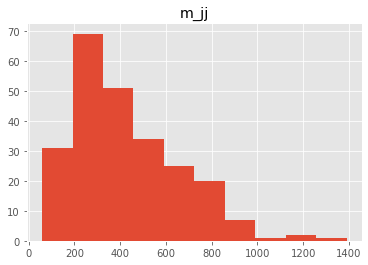

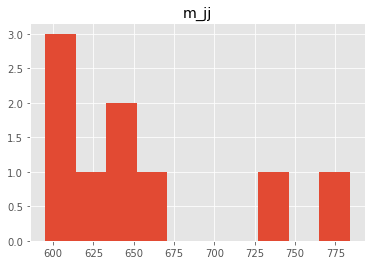

In [18]:
X_test.loc[X_test['pred']==0].hist('m_jj', color='blue')
X_test.loc[X_test['pred']==1].hist('m_jj')

array([[<AxesSubplot:title={'center':'eta_j1'}>]], dtype=object)

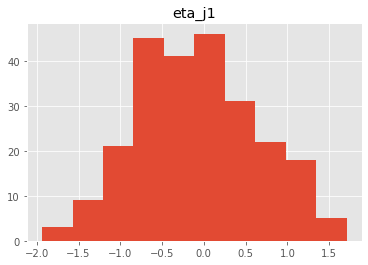

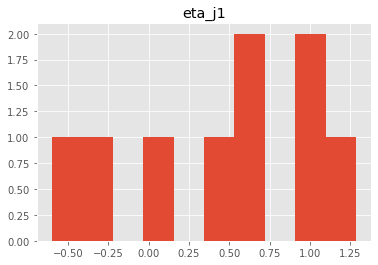

In [19]:
X_test.loc[X_test['pred']==0].hist('eta_j1', color='blue')
X_test.loc[X_test['pred']==1].hist('eta_j1')

In [21]:
del X_test['pred']

In [22]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

C:\Users\maria\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.95       0.8        0.75       0.9        0.8        0.8
 0.82666667 0.91       0.81       0.91       0.81       0.81
 0.92666667 0.91       0.89333333 0.9        0.91       0.89809524
        nan        nan        nan        nan        nan        nan
 0.95833333 0.975      0.96666667 0.975      0.975      0.975
 0.95       0.91666667 0.91666667 0.95714286 0.95714286 0.96
 0.95714286 0.91547619 0.89547619 0.91666667 0.90833333 0.95714286
        nan        nan        nan        nan        nan        nan
 0.96666667 0.95       0.96       0.95833333 0.88       0.96
 0.96666667 0.96666667 0.95714286 0.96666667 0.93214286 0.96666667
 0.86833333 0.90047619 0.94047619 0.90047619 0.86547619 0.91547619
        nan        nan        nan        nan        nan        nan
 0.96666667 0.96666667 0.98       0.96666667 0.96       0.96666667
 0.94047619 0.95

Best params for recall_score
{'max_depth': 15, 'max_features': 10, 'min_samples_split': 5, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       227         3
pos         9        11


In [24]:
X_test['pred'] = y_pred
X_test

<ipython-input-24-f01c86021f89>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['pred'] = y_pred


,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,m_jj,deltaR_j12,n_hadrones,pred
44180,1537.309450,303.448549,-0.225731,2.493708,1605.578676,0.564193,1260.457095,36.597861,1.082809,-0.573339,2074.786197,0.787685,340.046410,3.334524,146.0,0
10157,1507.522044,651.143290,0.238898,1.695591,1681.903831,0.203073,1491.614789,322.676061,0.265708,-1.460641,1577.924840,0.053450,973.819351,3.156346,174.0,0
24142,1496.671457,66.161674,-0.799884,1.159423,2002.640124,0.790490,1418.273727,160.100536,-0.242038,-1.873290,1468.771578,0.625889,226.262210,3.083592,213.0,0
2074,1435.214715,188.020006,0.463876,-0.982730,1603.480499,0.913578,1414.295610,34.655229,-0.954789,2.125690,2109.716899,0.725047,222.675235,3.416853,156.0,0
39942,1575.642223,75.189229,-0.056134,-1.739455,1579.915509,0.695679,1500.286497,47.564472,0.340090,1.383718,1588.600771,0.850589,122.753701,3.148206,93.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27187,1371.519557,58.888494,1.103841,-1.864608,2296.213728,0.707037,1354.400160,279.292141,-0.877957,1.275016,1931.098428,0.219238,338.180636,3.712784,104.0,0
42963,1300.474831,536.704233,-0.442375,-1.149363,1527.224392,0.243567,1160.480798,204.745873,-0.363688,1.965001,1254.893914,0.330511,741.450106,3.115358,160.0,0
13312,1843.044971,113.309947,0.180697,0.158994,1876.639684,0.935872,1634.077131,213.557547,0.695235,-2.976449,2056.279471,0.768617,326.867494,3.177382,179.0,0
38587,1353.746256,274.160215,0.126326,0.747291,1391.831202,0.286977,1308.123755,55.172268,0.206759,-2.420551,1337.322827,0.299698,329.332483,3.168863,131.0,0


In [ ]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score',
         'param_max_depth', 'param_max_features', 'param_min_samples_split',
         'param_n_estimators']].head()

array([[<AxesSubplot:title={'center':'pT_j1'}>]], dtype=object)

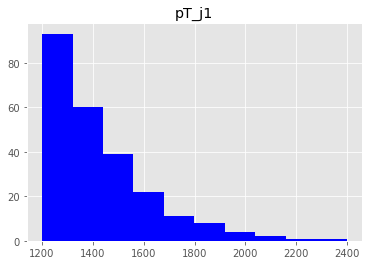

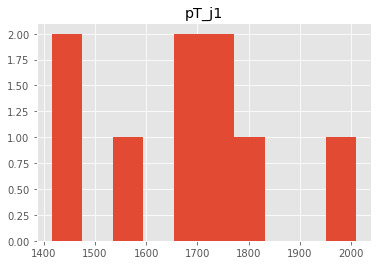

In [25]:
X_test.loc[X_test['pred']==0].hist('pT_j1', color='blue')
X_test.loc[X_test['pred']==1].hist('pT_j1')

array([[<AxesSubplot:title={'center':'m_jj'}>]], dtype=object)

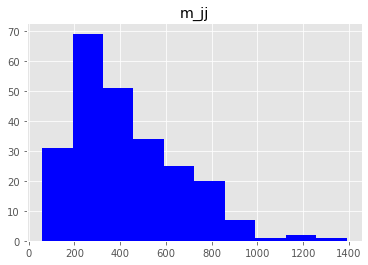

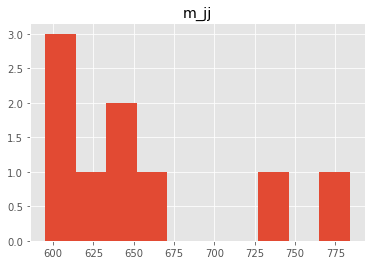

In [26]:
X_test.loc[X_test['pred']==0].hist('m_jj', color='blue')
X_test.loc[X_test['pred']==1].hist('m_jj')

array([[<AxesSubplot:title={'center':'eta_j1'}>]], dtype=object)

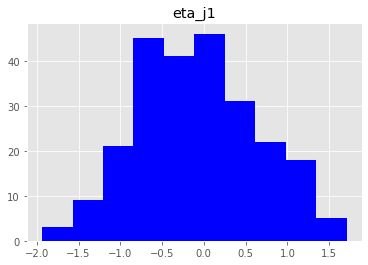

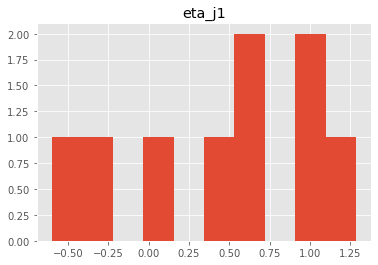

In [27]:
X_test.loc[X_test['pred']==0].hist('eta_j1', color='blue')
X_test.loc[X_test['pred']==1].hist('eta_j1')